Построим кривые удержания игроков c разбивкой по источникам привлечения channel

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index=dimensions,
        columns='lifetime',
        values='user_id',
        aggfunc='nunique',
    )
    cohort_sizes = (
        result_raw.groupby(dimensions)
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on=dimensions, how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    return result_raw, result_grouped

In [7]:

users = pd.read_csv('C:\\Users\\37544\\Downloads\\ch02_problems02_users.csv')   # профили
visits = pd.read_csv('C:\\Users\\37544\\Downloads\\ch02_problems02_visits.csv') # сессии

In [8]:
# преобразование данных о времени
users['dt'] = pd.to_datetime(users['dt']).dt.date
users['first_ts'] = pd.to_datetime(users['first_ts'])
visits['session_start'] = pd.to_datetime(visits['session_start'])

observation_date = users['dt'].max()  # момент анализа

analysis_horizon = 14  # горизонт анализа

retention_raw, retention = get_retention(users, visits, observation_date, analysis_horizon, dimensions=['channel'])

# исключаем размеры когорт и удержание первого дня
report = retention.drop(columns=['cohort_size', 0])

# задаём размер сетки для графиков
plt.figure(figsize = (20, 6))                 


<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

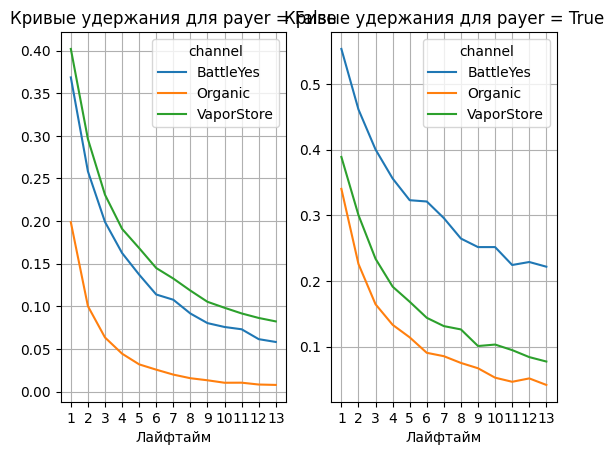

In [16]:
for i, payer in enumerate(users['payer'].unique()):
    report.query('payer == @payer').droplevel('payer').T.plot(
    grid=True,  
    xticks=list(report.columns.values),
    ax=plt.subplot(1, 2, i + 1), # задаём расположение графиков
    )
    
    plt.xlabel('Лайфтайм')
    plt.title('Кривые удержания для payer = {}'.format(payer))
plt.show()